# Tarea 1

Integrantes:
- Sara Sofía Rivera Sanabria.
- Juan Sebastián Rueda Segura.
- Santiago Rocha Pachón.

## Dependencias

In [2]:
!pip install matplotlib numpy

## Funciones auxiliares

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def graph_matrix(M: np.array, color_dict: dict) -> None:
    M = np.asarray(M)
    if M.ndim != 2:
        raise ValueError("M must be a 2D array")
    rows, cols = M.shape

    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_xticks(np.arange(0, cols))
    ax.set_yticks(np.arange(0, rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which="major", color="black", linewidth=1)
    ax.tick_params(length=0)

    cell_width_pts = (fig.get_figwidth() * 72) / max(cols, 1)
    cell_height_pts = (fig.get_figheight() * 72) / max(rows, 1)
    node_size = (0.35 * min(cell_width_pts, cell_height_pts)) ** 2

    for row in range(rows):
        for col in range(cols):
            value = M[row, col]
            if isinstance(value, np.generic):
                value = value.item()
            facecolor = color_dict[value]
            ax.scatter(col, row, s=node_size, c=facecolor, edgecolors="black", zorder=3)

    ax.set_aspect("equal")
    plt.show()


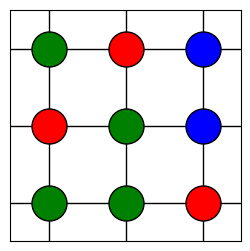

In [4]:
M: np.array = np.array([[1, 2, 3],
                        [2, 1, 3],
                        [1, 1, 2]])
color_dict: dict = {1: "green", 2: "red", 3: "blue"}
graph_matrix(M, color_dict)

## 1. Modelo *hard-core*

### Introducción

Es un algoritmo diseñado para encontrar el número de posibles configuraciones de un grafo (o si se prefiere, la distribución de una cadena de Markov asociada) dado que cada vértice tiene un 'peso' o valor asociado de dos que puede tomar.

#### El espacio de configuración

Tiene las siguientes características:

- Un grafo $G = (V, E)$ con:
  - $|V| = n \times n$ vértices ($n \in \mathbb{N}^+$).
  - $|E| = 2 \cdot (n-1) \cdot n$ aristas que conectan los vértices de modo que se forme una 'grilla'.
- Cada vértice puede tomar algún valor de un conjunto $S$ con dos elementos. 
 
Un ejemplo se muestra en la imagen a continuación:

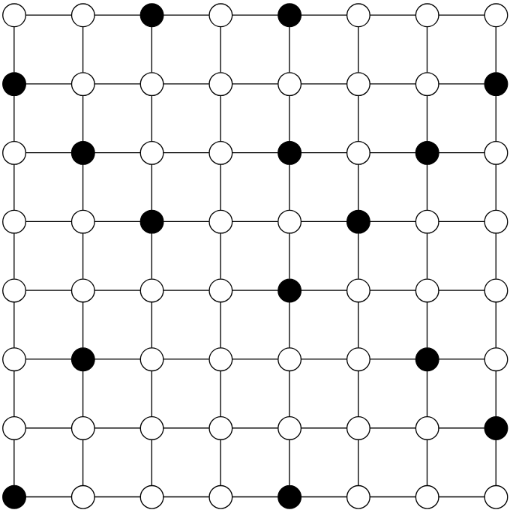

*Figura 1:* Modelo *hard-core* cuyo grafo asociado tiene $8 \times 8 = 64$ vértices y dos posibles 'colores' para cada vértice: blanco y negro.

En suma, es de interés saber cuáles configuraciones del grafo (i.e., asignándole a cada vértice ) son **factibles**. Estas son aquellas en las que, dado $S = \{b, w\}$, para todo vértice en $V$, si el vértice tiene valor asociado $b$, entonces ninguno de sus vecinos puede tener dicho valor asociado (es decir, todos sus vecinos deben tener valor $w$). De nuevo, un ejemplo de una configuración factible es la Figura 1.

> Nota: Sin pérdida de generalidad y siguiendo la mayoría de los textos que incluyen el modelo hard-core, $S$ será el conjunto $\{0, 1\}$, donde $1$ se representa como un vértice en negro y $0$ como un vértice en blanco.

#### El problema

El número de configuraciones posibles crece exponencialmente, pues, como cada vértice puede tener dos valores y hay $n^2$ de estos, habrán $2^{n^2}$ configuraciones posibles. Esto hace computacionalmente inviable inspeccionar si cada una de las configuraciones posibles es viable muy rápidamente a medida que se incrementa $n$.

¿Es ese el problema o es hallar una distribución estacionaria?

TODO: Consultar otras posibles formas de solucionar el problema.

#### La solución: una cadena de Markov

Si cualquiera de los valores de $S$ tiene la misma probabilidad de salir, y cada vértice puede ser escogido con la misma probabilidad, entonces cada una de las configuraciones factibles tendrá la misma probabilidad de salir si se asignan aleatorios (pero válidos) valores de $S$ a cada uno de los $n^2$ vértices. Además, de una configuración factible se puede llegar a otra alterando el valor de $S$ que tome un número de vértices menor a $|V| = n^2$.

Así pues, si se define un procedimiento capaz de ir de una configuración factible a otra tal que no hayan estados absorbentes, entonces se podrá diseñar una cadena de Markov irreducible y aperiódica cuya distribución estacionaria lucirá así:
$$
\mu_G(\eta) = 
\begin{cases}
\frac{1}{Z_G} & \text{si } \eta \text{ es una configuración factible.} \\
      0       & \text{en otro caso}
\end{cases}
$$
que es justamente lo que buscamos. De este modo, si se simula la cadena de Markov por un tiempo $t$ suficientemente grande, por el teorema de convergencia, $X_t \approx \pi$, y de este modo se podrá aproximar $Z_G$.

#### Primer paso: Muestrear $\mu_G$

Dicho procedimiento existe y es el siguiente: en el tiempo $n \in \mathbb{N}$,
1. Se elige un vértice $v \in V$ al azar (uniformemente).
2. Se lanza una moneda justa ($\mathbb{P}(C) = \mathbb{P}(S) = \frac{1}{2}$).
   1. Si sale cara, se pone un $1$ en $v$ ($X:{n + 1}(v) = 1$) si todos los vecinos de $v$ en la configuración de $X_n$ son $0$. De otro modo, se pone $0$ en $v$ ($X:{n + 1}(v) = 0$).
   2. Si sale sello, se pone $X:{n + 1}(v) = 0$ ($0$ en $v$ para la siguiente configuración).

Se vio en clase que esta distribución es reversible, aperiódica e irreducible, que era lo que necesitábamos. Ahora, se procederá a implementarlo.


### a) Implementación del muestreo

In [5]:
import random

import numpy as np

def determine_feasible_values(neighbors_values: list, S: list) -> list:
    neighs: set = list(set(neighbors_values))
    return [val for val in S if val not in neighs]

def get_neighbors_values(vertex: tuple, current_config: np.array) -> tuple:
    """Return values of all neighboo"""
    row: int = vertex[0]
    col: int = vertex[1]
    neighbors: list = []
    #*Left
    try:
        neighbors.append(current_config[row][col-1])
    except IndexError:
        pass
    #*Top
    try:
        neighbors.append(current_config[row-1][col])
    except IndexError:
        pass
    #*Right
    try:
        neighbors.append(current_config[row][col+1])
    except IndexError:
        pass
    #*Botttom
    try:
        neighbors.append(current_config[row+1][col])
    except IndexError:
        pass

    return neighbors

def count_n_of_x(config: list[list], x: any, S: list = ['w', 'b']) -> int:
    """
    Count the numbers of `x` in `config`, where `x` is an element of `S` and
    config is a lists of lists of elements of `S`
    """
    if x not in S:
        raise ValueError(f"x: {x} is not an element of S: {S}")
    
    count: int = 0
    for l in config:
        for y in l:
            if y == x:
                count+=1
                
    return count

def gibbs_sampler_hcm(k: int, initial_config: list[list], S: list = ['w', 'b'], n: int = 10000, show_each: int = 1000, verbose=False) -> list[list]:
    """
    Compute the $n$-th configuration value of a $k times k$ hard-core model using
    a Gibbs sampler that starts with an initial configuration `initial_config` 
    and updates it based on a uniform stationary distribution of the
    configurations which yields a fair-coin decision rule on which value to
    assign (from S) to each vertex. Also, it shows the current distribution
    every `show_each` using the `graph_matrix` helper.
    
    Parameters
    ----------
        k (int): A number such that `k`^2 is the number of vertices of the hard-core model to simulate.
        initial_distr (numpy.array): The initial configuration to start the simulation with. Must be a feasible configuration with `k`^2 entries.
        S (list): A list containing the unique possible values each vertex can take. The first one must be the one it can always take, and the second one the one we want no adjacent vertices of. Deafult is ['w', 'b'] for white and black, respectively.
        n (int, optional): The simulation will run up to step `n`. Default is 10000.
        show_each (int, optional): Every `show_each` simulations, the current distribution of the MCMC will be shown (as a graph). Set it to n+1 to run quietly. Default is 1000.
        verbose (bool, optional): Whether to print if a vertex cannot be updated due to the values of its neighbors.

    Returns
    -------
        numpy.array: An array of size $k^2$.
    """
    X: np.array = initial_config.copy()
    S_set: set = set(S)
    if len(set(S)) != len(S):
        raise Exception("a")
    for i in range(1, n + 1):
        #*1) Pick a vertex at random (but uniformly)
        rand1: int = random.randint(0, k*k - 1)
        vertex: tuple = (rand1 // k, rand1 % k)
        # print("Vertex:", vertex)

        #*2) Pick a random color from the uniform distribution of the possible colors vertex can take
        neighbors_vals: list = get_neighbors_values(vertex, X)
        feasible_values: list = determine_feasible_values(neighbors_vals, S)
        if S[0] not in feasible_values:
            feasible_values.append(S[0]) #*since 0 or white can always appear
        if len(feasible_values) == 0:
            if verbose:
                print(f"Neighbors have all {len(S)} values")
        else:
            rand2: int = random.randint(0, len(feasible_values) - 1)
            #*3) Update the chosen vertex according to the distribution and leave the rest unchanged
            X[vertex[0]][vertex[1]] = feasible_values[rand2]

        if show_each != 0:
            if i % show_each == 0:
                print(f"Configuration at {i} out of {n}")
                graph_matrix(X, {"b": "black", "w": "white"})

    return X


> Note: S was left as a list to be able to preserve its order

The configuration has 20 particles out of 100


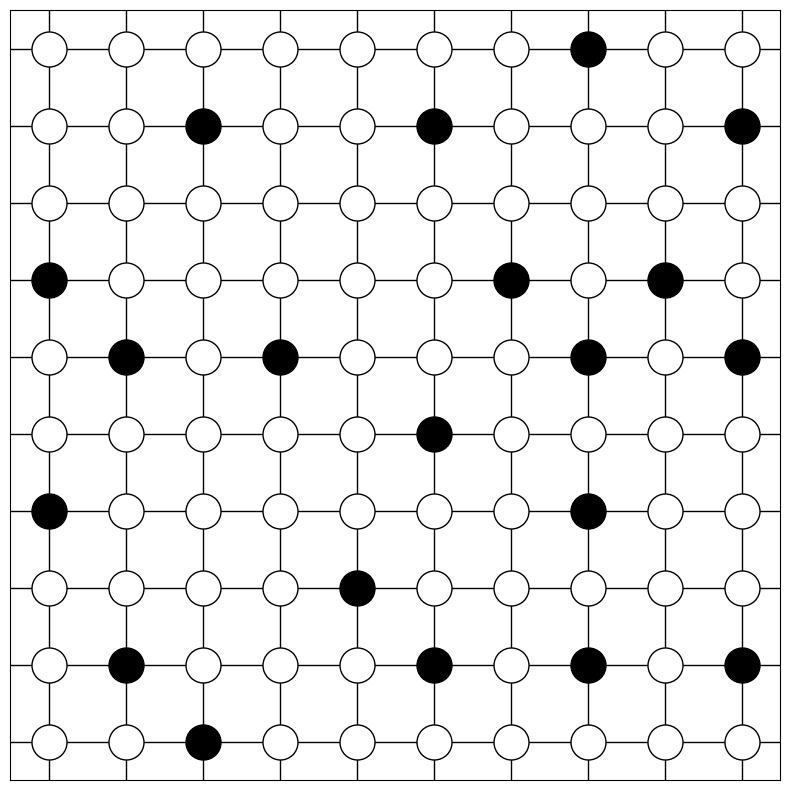

Configuration at 40 out of 100


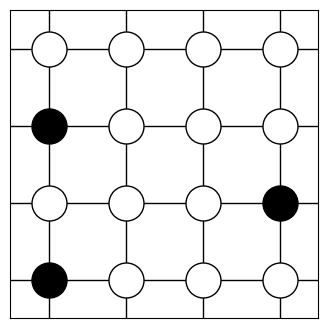

Configuration at 60 out of 100


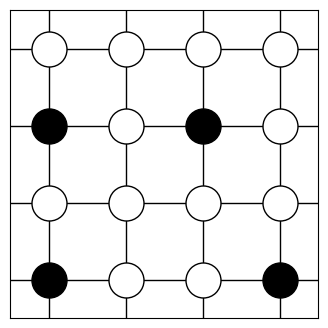

Configuration at 80 out of 100


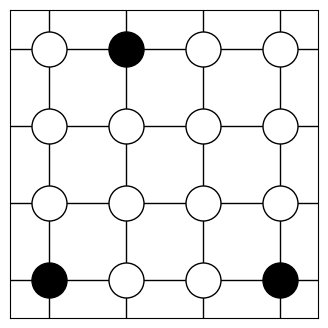

Configuration at 100 out of 100


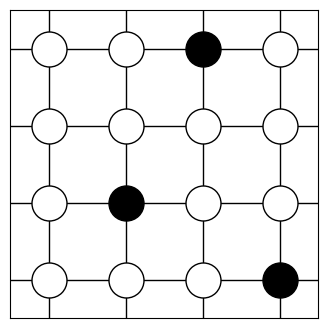

The final (or sample) configuration has 3 particles out of 16


In [6]:
k: int = 4
X0: list[list] = [k * ['w'] for _ in range(k)]
S: list = ['w', 'b']
n: int = 100

final_config: list[list] = gibbs_sampler_hcm(k, initial_config=X0, S = S, n=n, show_each=n/5)
# print(final_config)
n_particles: int = count_n_of_x(final_config, "b", S)
print(f"The final (or sample) configuration has {n_particles} particles out of {k * k}")
# graph_matrix(final_config, {"b": "black", "w": "white"})

### b) Estimar el número de partículas

In [31]:
def build_record(k: int, initial_config: list[list], S: list = ['w', 'b'], particle_id: str = 'b', num_sim: int = 200, n: int = n, color_dict: dict = {'b': "black", 'w': "white"}, verbose = False) -> None:
    """
    Build a record of the number of particles (`particle_id`) across
    `num_sim` simulations of a hard-core model of size `k`^2, initial
    config `initial_config`, and list of (unique) states `S`.

    This will be done using the Gibbs sampler to get a sample of mu_G
    with parameter `n` (in other words, each element of the record will
    be the configuration X_n).

    Parameters
    ----------
    TODO: Update parameters
    num_sim (int, optional): Number of simulations or iterations of the Gibbs sampler to be made.
    n (int, optional): Number of iterations to be made when running the Gibbs sampler (it will run up to n).
    """
    if particle_id not in S:
        raise ValueError(f"Particle ID {particle_id} is not in S: {S}")
    
    record: list[list[list]] = []
    Xn: list[list] = []
    for i in range(num_sim):
        Xn = (gibbs_sampler_hcm(k, initial_config, S, n, n+1))
        count: int = count_n_of_x(Xn, particle_id, S)
        if verbose:
            print(f"Count of {particle_id} at iteration {i}: {count}")
        record.append(count)

    return record

In [32]:
num_sim: int = 100
k: int = 5
X0: list[list] = [k * ['w'] for _ in range(k)]
S: list = ['w', 'b']
n: int = 1000

build_record(k, X0, S, 'b', num_sim, n)

[7,
 4,
 5,
 7,
 8,
 4,
 6,
 5,
 7,
 5,
 5,
 7,
 5,
 5,
 9,
 7,
 5,
 4,
 3,
 6,
 5,
 8,
 7,
 8,
 6,
 3,
 6,
 7,
 6,
 8,
 7,
 4,
 3,
 7,
 7,
 6,
 7,
 6,
 8,
 7,
 6,
 5,
 6,
 6,
 6,
 5,
 6,
 5,
 5,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 8,
 6,
 5,
 6,
 8,
 3,
 4,
 6,
 4,
 5,
 5,
 5,
 6,
 8,
 5,
 6,
 6,
 5,
 5,
 5,
 6,
 8,
 7,
 5,
 6,
 7,
 8,
 5,
 6,
 5,
 4,
 6,
 4,
 3,
 6,
 7,
 6,
 5,
 7,
 5,
 5,
 5,
 6,
 4]

In [33]:
def build_histogram_from_record(record: list, k: int, n: int, particle_id: str = 'b', color_dict = {'b': "black", 'w': "white"}, ax=None, show=True, label=None, color=None, alpha=0.6) -> None:
    """
    Create a histogram for particle (`particle_id`) count
    distribution/frequency from a simulations `record` of a H-C
    with `k`^2 number of vertices and using the Gibbs sampler up
    to the `n`-th step (computes X_n to estimate mu_G)

    Parameters
    ----------
    record (list): A list of positive integers assumed to be the number of particles observed at eac
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    #*Style and figure
    plt.style.use('seaborn-darkgrid' if 'seaborn-darkgrid' in plt.style.available else 'default')
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
   
    if len(record) == 0:
        return
    #*Get histogram data (so that the distribution of the bars is done uniformly)
    unique_values = sorted(set(record))
    counts = [record.count(val) for val in unique_values]

    #*Create bars with small gaps between them
    bar_width = 0.95
    bars = ax.bar(unique_values, counts, width=bar_width, 
                  color=color or 'steelblue', alpha=alpha, edgecolor='navy', linewidth=0.5, label=label or f"n={n}")
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(counts)*0.01,
            f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    mean_particles = np.mean(record)
    std_particles = np.std(record)
    max_particles = max(record)
    min_particles = min(record)
    #*Add titles and labels
    if show:
        ax.set_xlabel(f'Number of {color_dict[particle_id]} particles', fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title(f'Distribution of Particles in Hard-Core Model\n'
                f'Grid: {k}×{k}  -  Iterations (n in X_n): {n}  -  Simulations: {len(record)}', 
                fontsize=14, fontweight='bold', pad=20)
    
    #*Set integer ticks on x-axis
        ax.set_xticks(unique_values)
        ax.set_xticklabels(unique_values)
    
    #*Add grid for better readability
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
    
    #*Add statistics text box
    
        stats_text = f"""Mean: {mean_particles:.2f}\nStd: {std_particles:.2f}\nRange: [{min_particles}, {max_particles}]"""
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)
        ax.legend()
    # Adjust layout and show
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f"\nHistogram Summary for different number of iterations:")
    print(f" -TOTAL ITERATIONS: {n}")
    print(f" -Total simulations: {len(record)}")
    print(f" -Particle range: {min_particles} to {max_particles}")
    print(f" -Mean particles: {mean_particles:.2f} ± {std_particles:.2f}")
    print(f" -Most frequent count: {max(unique_values, key=record.count)} (appears {max(counts)} times)")

EJEMPLO DE VISUALIZACION CON K=4, MIL ITERACIONES DENTRO DE CADA MUESTREO Y MIL MUESTRAS

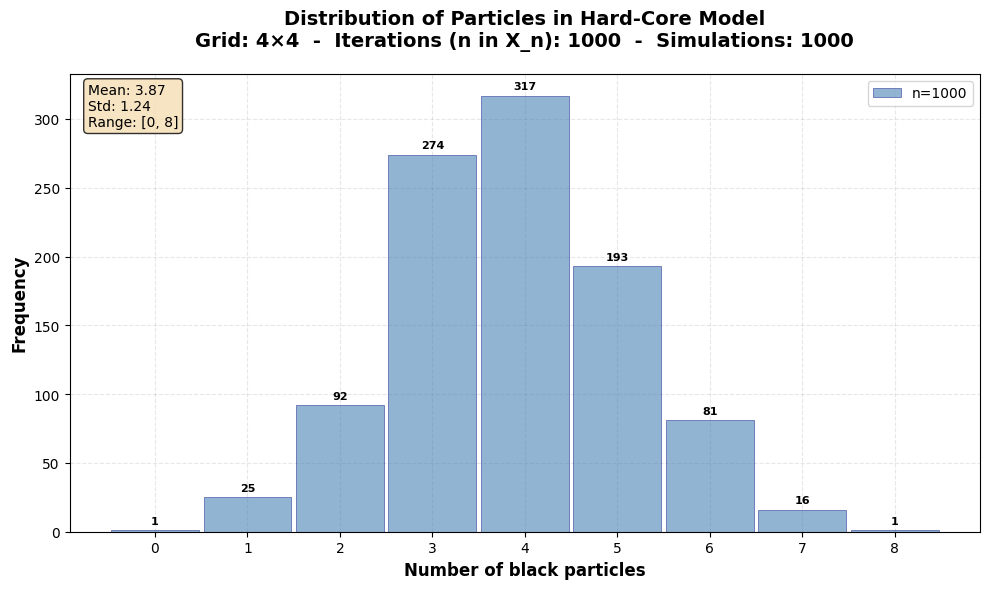


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 0 to 8
 -Mean particles: 3.87 ± 1.24
 -Most frequent count: 4 (appears 317 times)


In [34]:
num_sim: int = 1000
k: int = 4
X0: list[list] = [k * ['w'] for _ in range(k)]
S: list = ['w', 'b']
n: int = 1000

record = build_record(k, X0, S, 'b', num_sim, n)
build_histogram_from_record(record, k, n)

---

**Experimento que estima el número de particulas “tipico” que tiene una configuración factible en la rejilla K × K. Se genera un histograma de frecuencias para cada K variante entre 3 y 20.**


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 0 to 5
 -Mean particles: 2.00 ± 0.76
 -Most frequent count: 2 (appears 513 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 0 to 4
 -Mean particles: 1.95 ± 0.78
 -Most frequent count: 2 (appears 489 times)


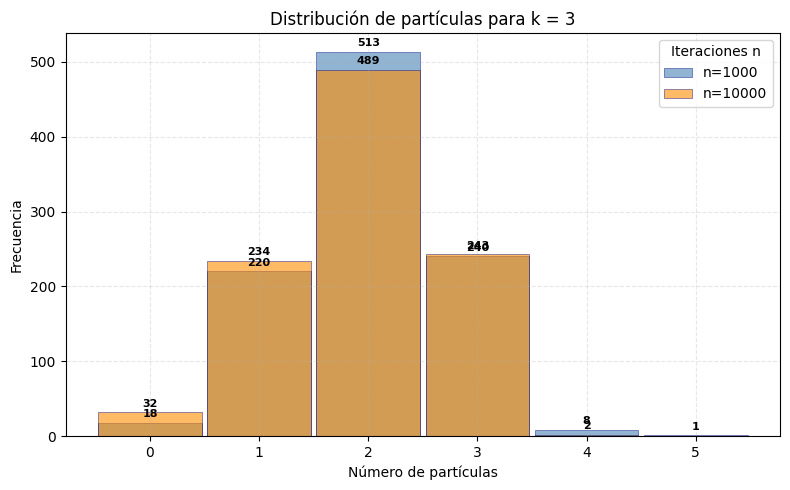


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 0 to 8
 -Mean particles: 3.86 ± 1.22
 -Most frequent count: 4 (appears 321 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 0 to 8
 -Mean particles: 3.83 ± 1.25
 -Most frequent count: 4 (appears 319 times)


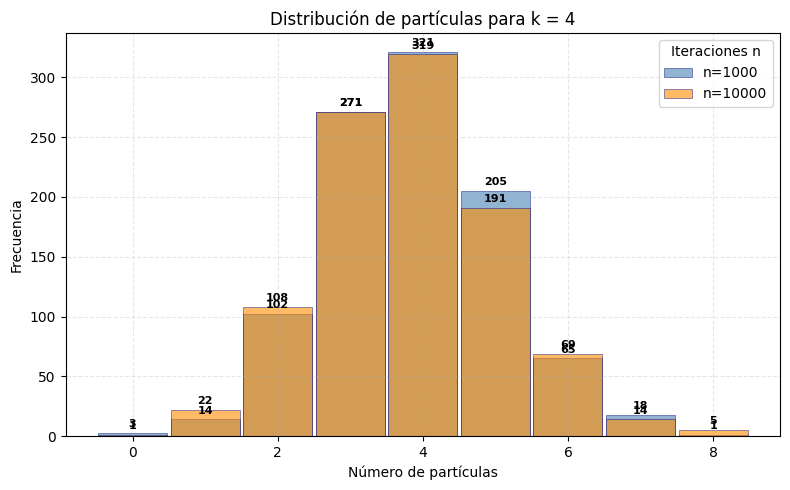


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 1 to 9
 -Mean particles: 5.64 ± 1.32
 -Most frequent count: 6 (appears 295 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 0 to 10
 -Mean particles: 5.74 ± 1.37
 -Most frequent count: 6 (appears 292 times)


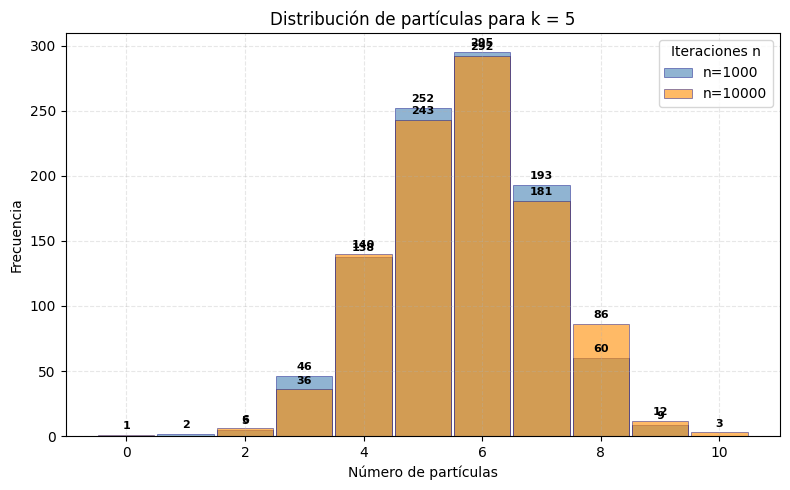


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 3 to 15
 -Mean particles: 8.35 ± 1.72
 -Most frequent count: 8 (appears 229 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 4 to 14
 -Mean particles: 8.38 ± 1.74
 -Most frequent count: 8 (appears 212 times)


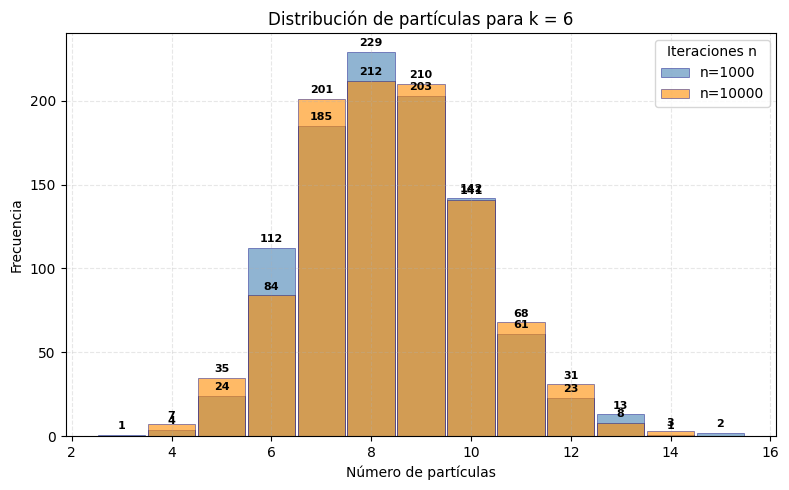


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 6 to 18
 -Mean particles: 11.24 ± 2.01
 -Most frequent count: 11 (appears 195 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 5 to 17
 -Mean particles: 11.34 ± 1.97
 -Most frequent count: 11 (appears 201 times)


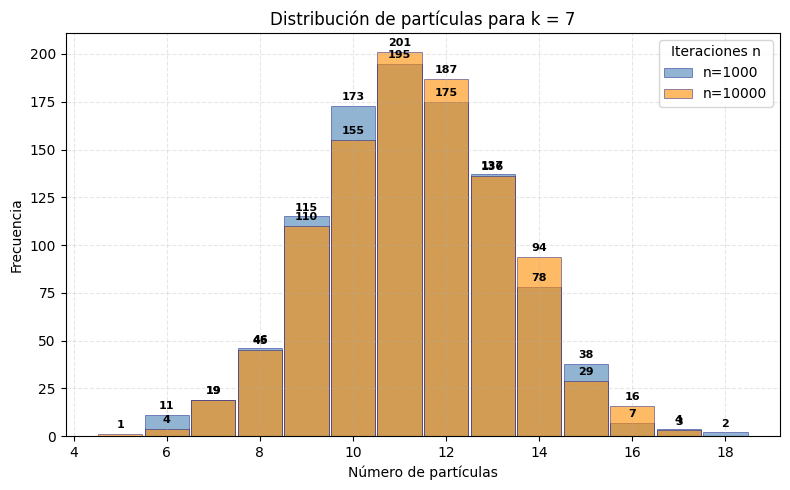


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 9 to 21
 -Mean particles: 14.67 ± 2.25
 -Most frequent count: 14 (appears 184 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 7 to 23
 -Mean particles: 14.71 ± 2.39
 -Most frequent count: 14 (appears 180 times)


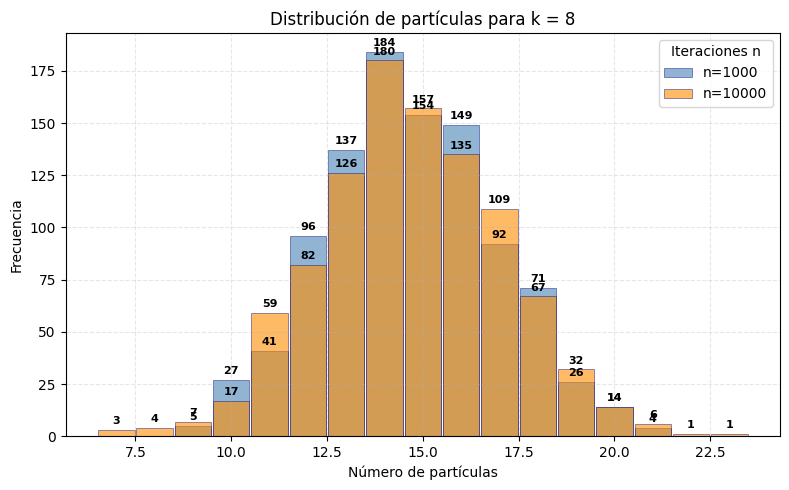


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 10 to 27
 -Mean particles: 18.57 ± 2.59
 -Most frequent count: 19 (appears 148 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 10 to 29
 -Mean particles: 18.65 ± 2.60
 -Most frequent count: 19 (appears 158 times)


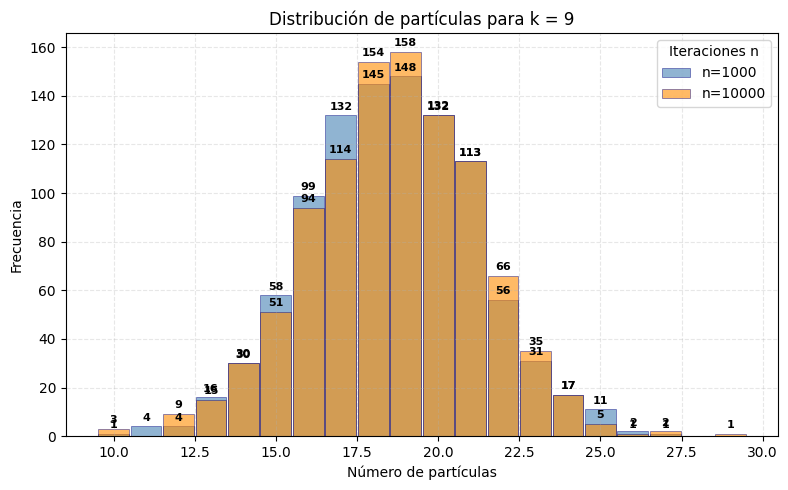


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 14 to 33
 -Mean particles: 22.96 ± 2.90
 -Most frequent count: 22 (appears 145 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 15 to 31
 -Mean particles: 22.96 ± 2.76
 -Most frequent count: 22 (appears 147 times)


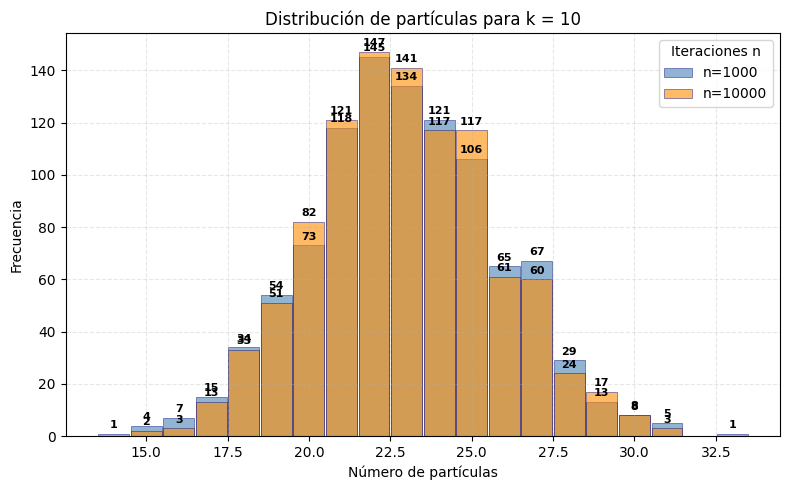


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 16 to 37
 -Mean particles: 27.72 ± 3.20
 -Most frequent count: 27 (appears 133 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 15 to 39
 -Mean particles: 27.69 ± 3.24
 -Most frequent count: 27 (appears 126 times)


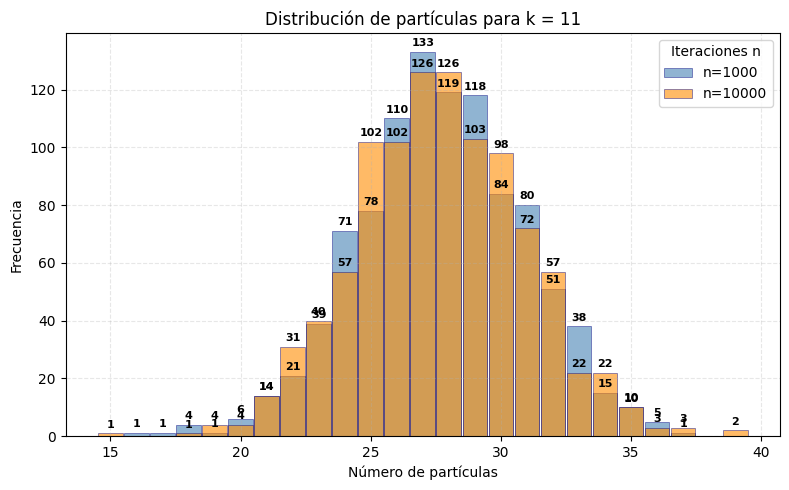


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 22 to 43
 -Mean particles: 32.82 ± 3.40
 -Most frequent count: 32 (appears 122 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 22 to 44
 -Mean particles: 32.75 ± 3.47
 -Most frequent count: 33 (appears 131 times)


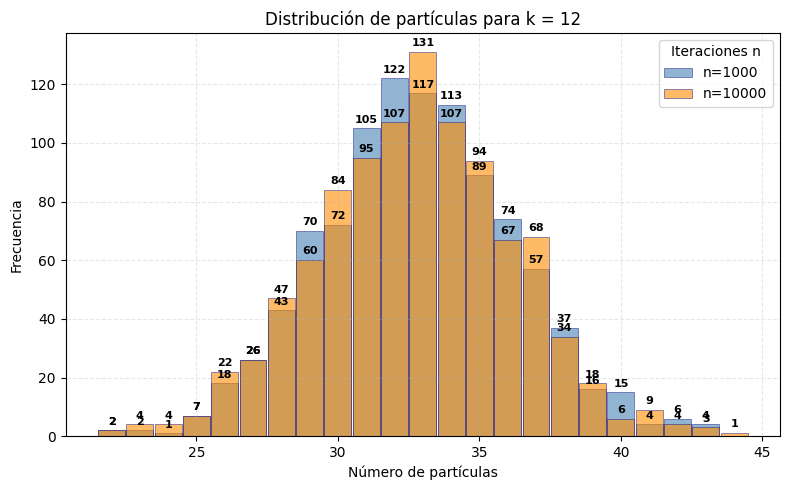


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 27 to 49
 -Mean particles: 38.59 ± 3.65
 -Most frequent count: 38 (appears 111 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 26 to 51
 -Mean particles: 38.66 ± 3.70
 -Most frequent count: 39 (appears 115 times)


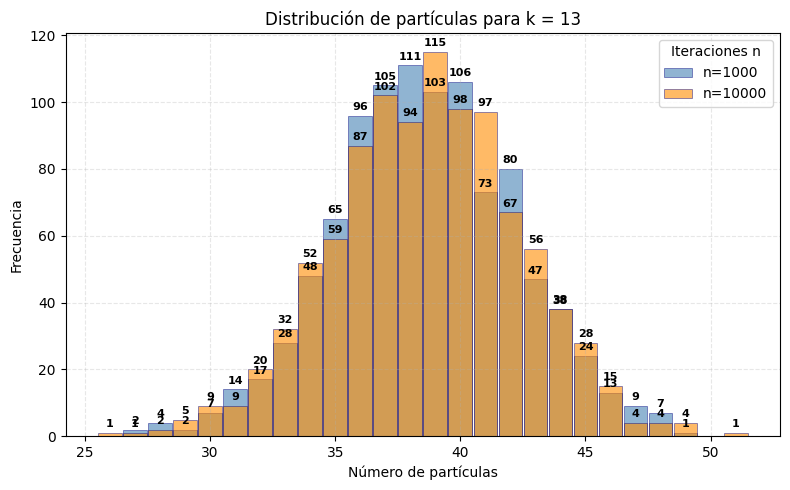


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 32 to 56
 -Mean particles: 44.44 ± 4.04
 -Most frequent count: 44 (appears 94 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 32 to 58
 -Mean particles: 44.82 ± 4.09
 -Most frequent count: 46 (appears 105 times)


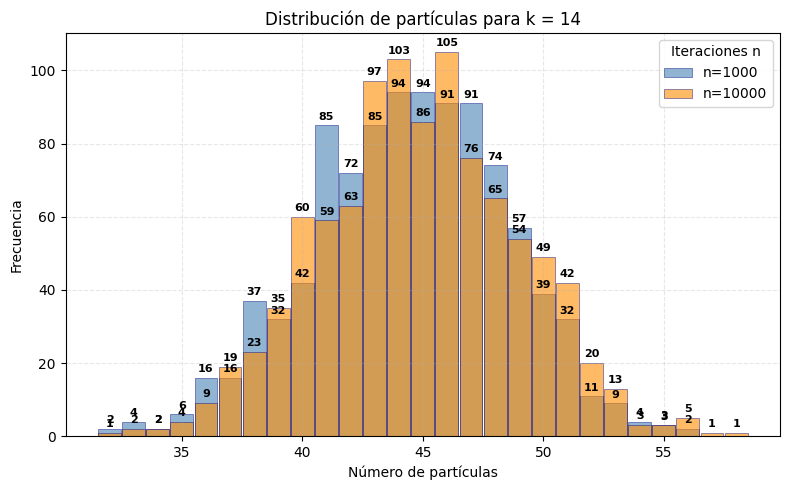


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 39 to 64
 -Mean particles: 51.09 ± 4.19
 -Most frequent count: 52 (appears 107 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 40 to 71
 -Mean particles: 51.53 ± 4.53
 -Most frequent count: 52 (appears 90 times)


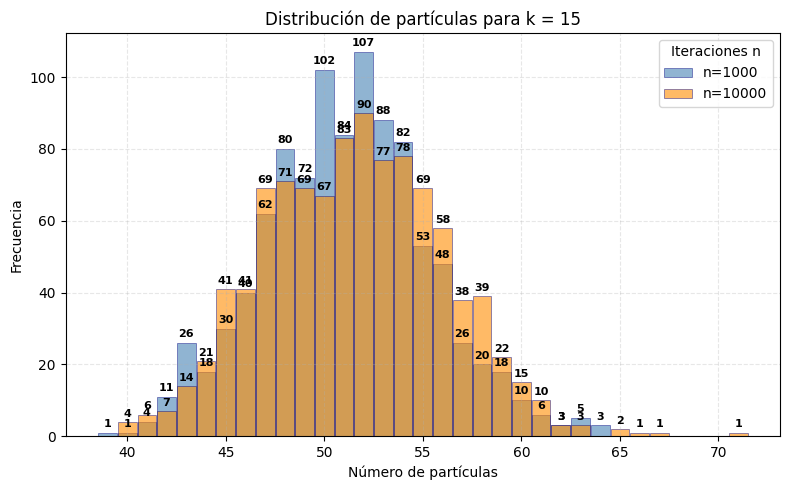


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 44 to 76
 -Mean particles: 58.70 ± 4.82
 -Most frequent count: 59 (appears 82 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 46 to 74
 -Mean particles: 58.41 ± 4.42
 -Most frequent count: 59 (appears 100 times)


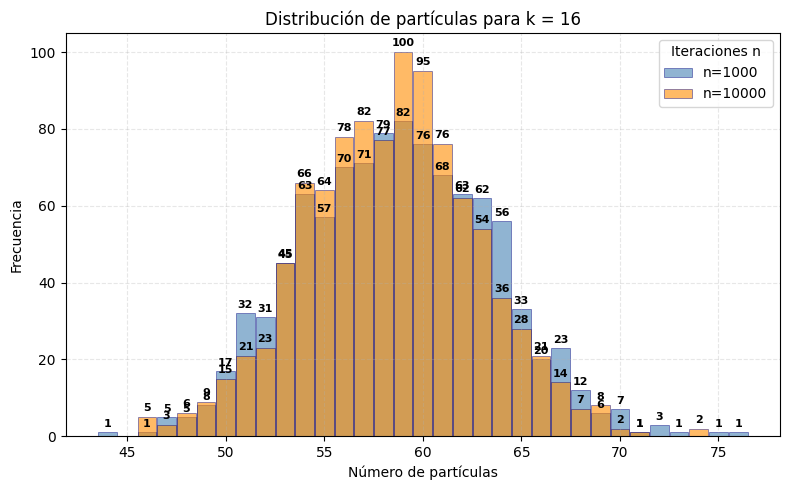


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 52 to 81
 -Mean particles: 65.62 ± 4.75
 -Most frequent count: 66 (appears 83 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 51 to 82
 -Mean particles: 65.72 ± 4.82
 -Most frequent count: 66 (appears 91 times)


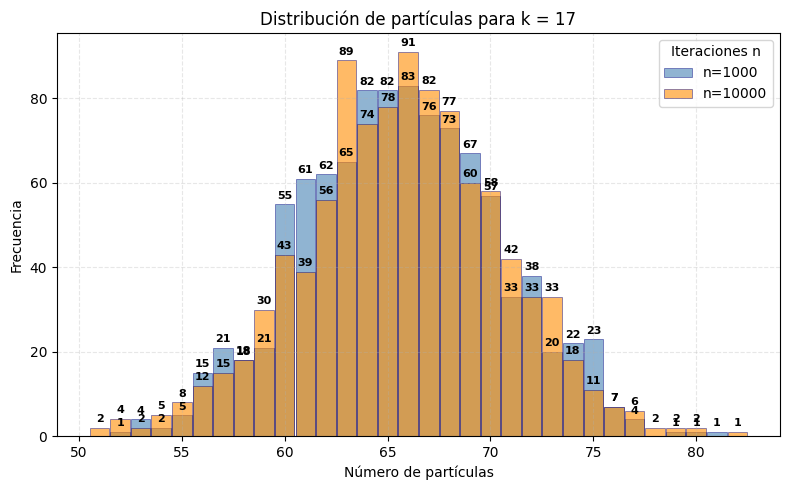


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 57 to 92
 -Mean particles: 73.80 ± 5.14
 -Most frequent count: 72 (appears 82 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 60 to 89
 -Mean particles: 73.91 ± 4.94
 -Most frequent count: 73 (appears 83 times)


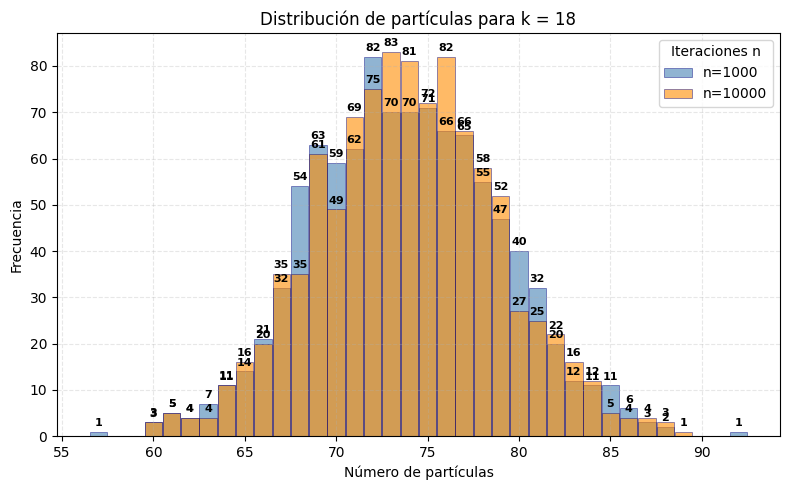


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 63 to 98
 -Mean particles: 82.35 ± 5.48
 -Most frequent count: 81 (appears 86 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 65 to 100
 -Mean particles: 82.14 ± 5.53
 -Most frequent count: 81 (appears 76 times)


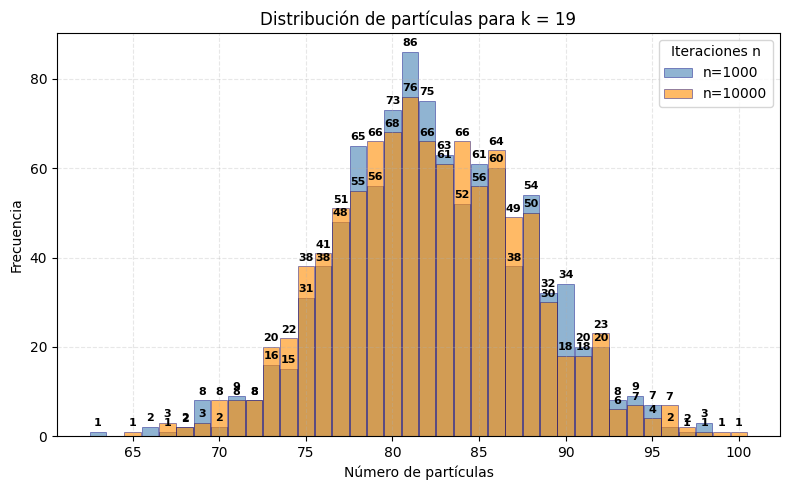


Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 1000
 -Total simulations: 1000
 -Particle range: 75 to 108
 -Mean particles: 91.02 ± 5.61
 -Most frequent count: 91 (appears 78 times)

Histogram Summary for different number of iterations:
 -TOTAL ITERATIONS: 10000
 -Total simulations: 1000
 -Particle range: 73 to 107
 -Mean particles: 91.45 ± 5.59
 -Most frequent count: 89 (appears 77 times)


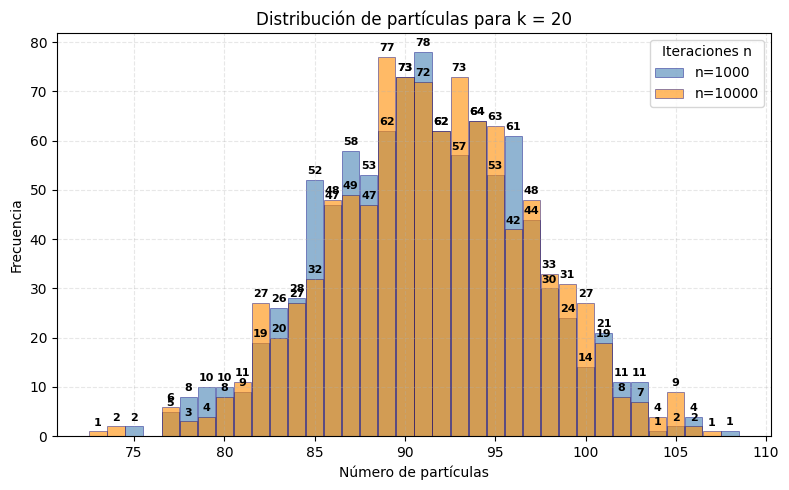

In [36]:
Ks = range(3, 21)
ns = [1000, 10000]
num_sims = [1000]
S = ['w', 'b']
particle_id = 'b'

colors = ['steelblue', 'darkorange']

for k in Ks:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    for color, n in zip(colors, ns):
        for num_sim in num_sims:
            X0 = [k * ['w'] for _ in range(k)]
            record = build_record(k, X0, S, particle_id, num_sim=num_sim, n=n)
            build_histogram_from_record(record, k, n, particle_id, ax=ax, show=False,
                                        label=f"n={n}", color=color, alpha=0.6)
    
    ax.set_title(f"Distribución de partículas para k = {k}")
    ax.set_xlabel("Número de partículas")
    ax.set_ylabel("Frecuencia")
    ax.legend(title="Iteraciones n")
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

## 2. Gibbs sampler para q-coloraciones.

Es un caso más general al modelo hard-core. El primer paso será escoger aleatoriamente un vértice en la cuadrilla y ver su color. Posteriormente llamamos una función que nos da una lista con los colores válidos, los que hacen que una modificación al color de la casilla permita una q-coloración válida, es decir, un color diferente al de los vecinos. De esta lista escogemos aleatoriamente uno entre ellos para reemplazar el valor en la casilla. Esto garantiza que construimos una cadena de Markov con la distribución que queremos.

Como se demostró, esta cadena es irreducible, aperiódica y reversible, por lo que su distribución estacionaria convergerá a 

$\mu_G(\eta) = \begin{cases} \frac{1}{Z_G} & \text{si } \eta \text{ es una configuración factible.} \\ 0 & \text{en otro caso} \end{cases}$ 

Como no sabemos la cota de tiempo para que converja, estimaremos con $n = 10000, n = 100000$ para ver si se aproxima al valor deseado.

Como se mencionó en clase, hay varias maneras de inicializar esta cadena: escogiendo una configuración aleatoria, lo que puede que no genere una q-coloración; que todas las casillas empiecen en un color fijo, por ejemplo blanco; o como el ejemplo que se dio en clase, que los colores estén organizados diagonalmente, lo que garantiza una q-coloración, para $3 \leq q$.

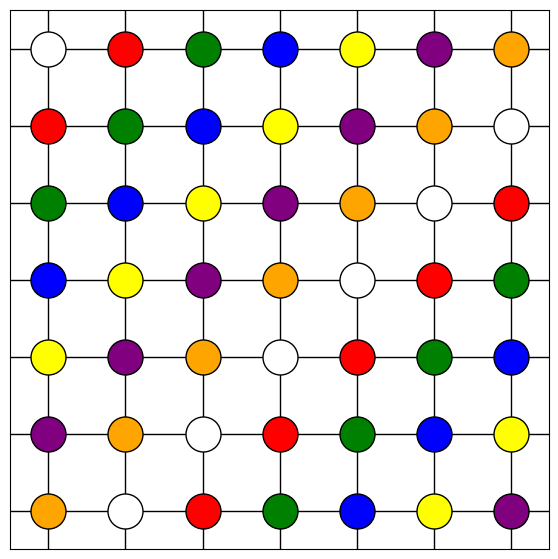

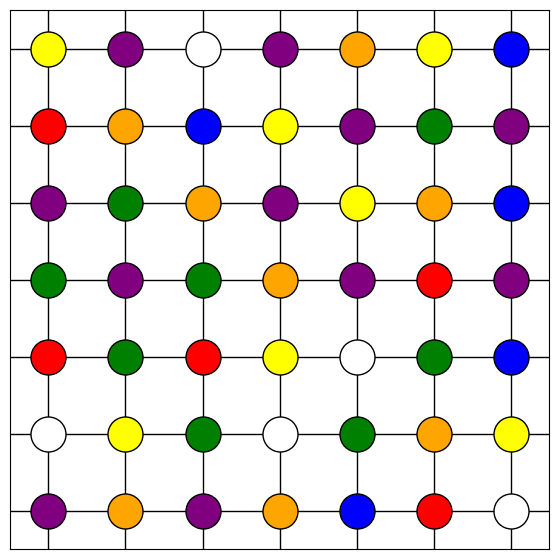

{'white': 5,
 'red': 5,
 'green': 8,
 'blue': 5,
 'yellow': 7,
 'purple': 11,
 'orange': 8}

In [30]:
def valid_colors(x, y, grid: np.ndarray, colors) -> list:
    """ 
    Given a position (x, y) in the grid, return the list of colors that can be assigned to that position without violating the coloring constraints.
    """
    # ! Realized might be better to use set
    neighbors_colors = []
    grid_size = grid.shape[0]
    if x > 0:
        neighbors_colors.append(grid[x - 1, y])
    if x < grid_size - 1:
        neighbors_colors.append(grid[x + 1, y])
    if y > 0:
        neighbors_colors.append(grid[x, y - 1])
    if y < grid_size - 1:
        neighbors_colors.append(grid[x, y + 1])

    valid_color = [c for c in colors if c not in neighbors_colors]

    return valid_color

def gibbs_sampler_q_coloration_random_start(grid_size: int, colors: list, iterations: int) -> np.ndarray:
    """
    Pick a random initial configuration and perform Gibbs sampling to color the grid.
    The Gibbs sampler picks a random cell and reassigns it a color that does not violate the coloring constraints.
    """
    grid = np.random.choice(colors, size=(grid_size, grid_size)) # Inicializar con colores aleatorios, puede que no sea válida la configuración

    for _ in range(iterations):
        (x, y) = np.random.randint(0, grid_size, size=2)
        valid_color = valid_colors(x, y, grid, colors)
        if valid_color:
            grid[x, y] = np.random.choice(valid_color)

    return grid

def gibbs_sampler_q_coloration_diagonal_colors(grid_size: int, color_dict: dict, iterations: int) -> np.ndarray:
    """ 
    Initialize the grid with diagonal colors and perform Gibbs sampling to color the grid.
    Example of diagonal colors for 3 colors:
    [[1,2,3],
     [2,3,1],
     [3,1,2]]
    """
    
    colors = list(color_dict.keys())
    grid = np.zeros((grid_size, grid_size), dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            grid[i, j] = colors[(i + j) % len(colors)]

    graph_matrix(grid, color_dict)
    
    for _ in range(iterations):
        (x, y) = np.random.randint(0, grid_size, size=2)
        valid_color = valid_colors(x, y, grid, colors)
        if valid_color:
            grid[x, y] = np.random.choice(valid_color)
    graph_matrix(grid, color_dict)
    return grid

def gibbs_sampler_q_coloration_blank(grid_size: int, color_dict: dict, iterations: int) -> np.ndarray:
    """
    Initialize the grid "empty", just assigning white to every cell and perform Gibbs sampling to color the grid.
    """
    grid = np.zeros((grid_size, grid_size), dtype=int)

    colors = list(color_dict.keys())
    
    graph_matrix(grid, color_dict)

    for _ in range(iterations):
        (x, y) = np.random.randint(0, grid_size, size=2)
        valid_color = valid_colors(x, y, grid, colors)
        if valid_color:
            grid[x, y] = np.random.choice(valid_color)
    graph_matrix(grid, color_dict)
    return grid

def count_number_of_particles(grid: np.ndarray, colors: dict) -> int:
    ret = {}
    size = grid.shape[0]
    for color in colors.keys():
        n = 0
        for i in range(size):
            for j in range(size):
                if grid[i, j] == color:
                    n += 1
        ret[colors[color]] = n
    return ret

colors_dict_1 = {1: "red", 2: "green", 3: "blue"}
colors_dict_2 = {0: "white", 1: "red", 2: "green", 3: "blue", 4: "yellow", 5: "purple", 6: "orange"}

g = gibbs_sampler_q_coloration_diagonal_colors(grid_size=7, color_dict=colors_dict_2, iterations=1000)
n= count_number_of_particles(g, colors_dict_2)
n